In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocess import load_dir, preprocess_and_save_images, divide_to_train_end_test

In [3]:
from work_with_keras_nets import shuffle_Xy, create_net_with_name, one_hot, plot_confusion_matrix

In [4]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '1' #use GPU with ID=1
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [5]:
# fix random seed for reproducibility
np.random.seed(42)

In [6]:
def load_dir_with_files_divided_to_5(directory, target_names):
    X_lt = []
    X_rt = []
    X_lb = []
    X_rb = []
    X_ct = []
    
    y_lt = []
    y_rt = []
    y_lb = []
    y_rb = []
    y_ct = []    
    
    for root, dirs, files in os.walk(directory):
        for name in files:
            file_path = os.path.join(root, name)
            target_name_dir_path, corner_name = os.path.split(root)
            _, target_name = os.path.split(target_name_dir_path)
            
            cur_X = imread(file_path)
            
            # сравниваем считанный target_name с названиями из target_names
            cur_y = target_names.index(target_name)
            
            if corner_name == "left_top":
                X_lt.append(cur_X)
                y_lt.append(cur_y)
            if corner_name == "right_top":
                X_rt.append(cur_X)
                y_rt.append(cur_y)
            if corner_name == "left_bottom":
                X_lb.append(cur_X)
                y_lb.append(cur_y)
            if corner_name == "right_bottom":
                X_rb.append(cur_X)
                y_rb.append(cur_y)
            if corner_name == "center":
                X_ct.append(cur_X)
                y_ct.append(cur_y)
                
    return np.array(X_lt), np.array(y_lt), np.array(X_rt), np.array(y_rt), np.array(X_lb), np.array(y_lb), \
np.array(X_rb), np.array(y_rb), np.array(X_ct), np.array(y_ct)
    

In [7]:
%%time
X_lt_U, y_lt_U, X_rt_U, y_rt_U, X_lb_U, y_lb_U, X_rb_U, y_rb_U, X_ct_U, y_ct_U \
= load_dir_with_files_divided_to_5("D:/svruchtel/PREPROCESSED_DATA/USA_New_128_3dim",
                                ["Airfare", "CarRental", "Fuel", "GeneralRetail", "Hotel",
                                 "Other", "Parking", "Restaurant", "Taxi", "Toll", "Transport"])

Wall time: 42 s


In [8]:
X_lt_U.shape

(6153, 128, 128, 3)

In [9]:
def print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count):
    ### CONFUSION MATRIX 
    
    y_pred_train = model.predict(X_train)
    cnf_matrix = confusion_matrix(one_hot(y_train, categories_count).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

    y_pred_test = model.predict(X_test)
    cnf_matrix = confusion_matrix(one_hot(y_test, categories_count).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

In [10]:
### VGG16, without retrain

def run_VGG16_without_retrain_on_dataset(X_train, y_train, X_test, y_test, categories_count, patience):
    
    model_app = VGG16(input_shape=X_train[0].shape, include_top=False)
    model_app.trainable = False
    
    model = Sequential()
    model.add(model_app)
    model.add(Flatten())
    #model.add(Dropout(0.4))
    #model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(categories_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    history_callback = model.fit(X_train, one_hot(y_train, categories_count), 
                                 validation_data=(X_test, one_hot(y_test, categories_count)),
                                 epochs=300, batch_size=2, callbacks=[callback])

    test_scores = model.evaluate(X_test, one_hot(y_test, categories_count), verbose=0)
    
    print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count)
    
    return model, history_callback, test_scores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                90123     
Total params: 14,804,811
Trainable params: 90,123
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/300
5531/5531 [==============================] - 87s 16ms/step - loss: 7.4416 - acc: 0.5299 - val_loss: 6.3052 - val_acc: 0.5965
Epoch 2/300
5531/5531 [==============================] - 82s 15ms/st

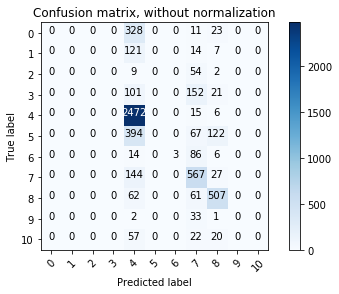

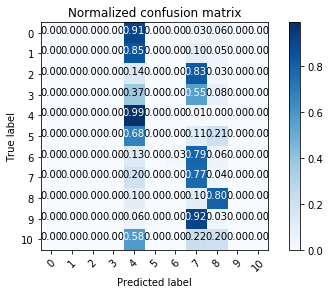

Confusion matrix, without normalization
[[  0   0   0   0  38   0   0   3   0   0   0]
 [  0   0   0   0  11   0   0   5   0   0   0]
 [  0   0   0   0   0   0   0   8   0   0   0]
 [  0   0   0   0   1   0   0  30   0   0   0]
 [  0   0   0   0 261   0   0  13   4   0   0]
 [  0   0   0   0  19   0   0  29  17   0   0]
 [  0   0   0   0   3   0   0  10   0   0   0]
 [  0   0   0   0   3   0   0  79   1   0   0]
 [  0   0   0   0   9   0   0  10  52   0   0]
 [  0   0   0   0   1   0   0   3   0   0   0]
 [  0   0   0   0   6   0   0   6   0   0   0]]
Normalized confusion matrix
[[0.         0.         0.         0.         0.92682927 0.
  0.         0.07317073 0.         0.         0.        ]
 [0.         0.         0.         0.         0.6875     0.
  0.         0.3125     0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.03225806 0.


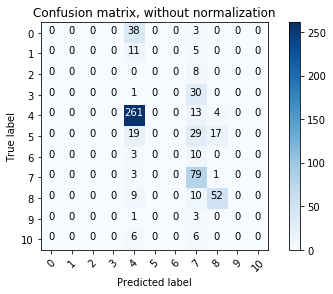

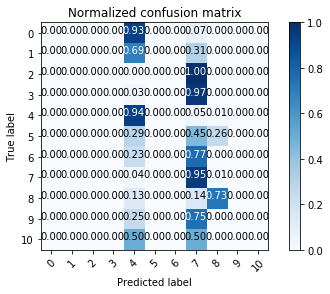

Wall time: 19min 35s


In [11]:
%%time
X_ct_train, y_ct_train, X_ct_test, y_ct_test = divide_to_train_end_test(X_ct_U, y_ct_U, num_categories=11)


model_ct, history_ct, test_scores_ct = run_VGG16_without_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=11,
                                                                           patience=7)

In [12]:
print("center result accuracy %.4f" % test_scores_ct[1])

center result accuracy 0.6302


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                90123     
Total params: 14,804,811
Trainable params: 90,123
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/300
5531/5531 [==============================] - 83s 15ms/step - loss: 7.6542 - acc: 0.5160 - val_loss: 7.2537 - val_acc: 0.5450
Epoch 2/300
5531/5531 [==============================] - 82s 15ms/st

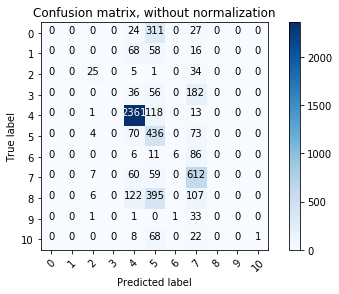

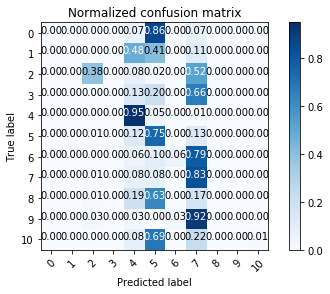

Confusion matrix, without normalization
[[  0   0   0   0   1  39   0   1   0   0   0]
 [  0   0   0   0   4   5   0   7   0   0   0]
 [  0   0   0   0   1   0   0   7   0   0   0]
 [  0   0   1   0   0   1   0  29   0   0   0]
 [  0   0   0   0 245  20   0  13   0   0   0]
 [  0   0   9   0   1  23   0  32   0   0   0]
 [  0   0   0   0   3   0   0  10   0   0   0]
 [  0   0   0   0   1   1   0  81   0   0   0]
 [  0   0   1   0  23  30   0  17   0   0   0]
 [  0   0   0   0   0   1   0   3   0   0   0]
 [  0   0   0   0   5   0   0   7   0   0   0]]
Normalized confusion matrix
[[0.         0.         0.         0.         0.02439024 0.95121951
  0.         0.02439024 0.         0.         0.        ]
 [0.         0.         0.         0.         0.25       0.3125
  0.         0.4375     0.         0.         0.        ]
 [0.         0.         0.         0.         0.125      0.
  0.         0.875      0.         0.         0.        ]
 [0.         0.         0.03225806 0.         0.

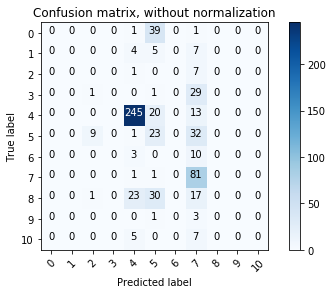

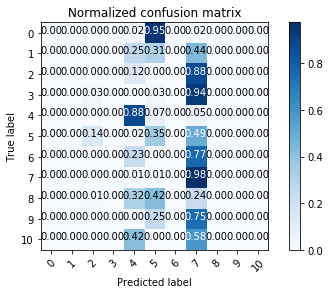

Wall time: 17min 17s


In [13]:
%%time
X_lt_train, y_lt_train, X_lt_test, y_lt_test = divide_to_train_end_test(X_lt_U, y_lt_U, num_categories=11)


model_lt, history_lt, test_scores_lt = run_VGG16_without_retrain_on_dataset(X_lt_train, y_lt_train,
                                                                           X_lt_test, y_lt_test,
                                                                           categories_count=11,
                                                                           patience=7)

In [14]:
print("left_top result accuracy: %.4f" % test_scores_lt[1])

left_top result accuracy: 0.5611


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                90123     
Total params: 14,804,811
Trainable params: 90,123
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/300
5531/5531 [==============================] - 82s 15ms/step - loss: 7.7001 - acc: 0.5153 - val_loss: 7.6023 - val_acc: 0.5225
Epoch 2/300
5531/5531 [==============================] - 81s 15ms/st

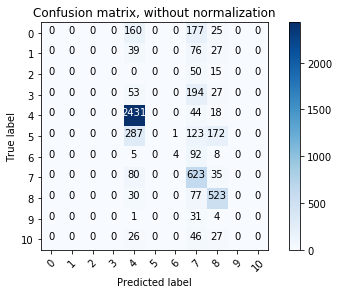

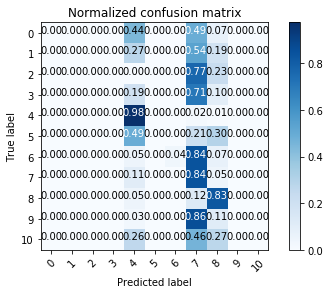

Confusion matrix, without normalization
[[  0   0   0   0  29   0   0  12   0   0   0]
 [  0   0   0   0   6   0   0   9   1   0   0]
 [  0   0   0   0   1   0   0   7   0   0   0]
 [  0   0   0   0   0   0   0  29   2   0   0]
 [  0   0   0   0 253   0   0  21   4   0   0]
 [  0   0   0   0   8   0   0  40  17   0   0]
 [  0   0   0   0   1   0   0  11   1   0   0]
 [  0   0   0   0   0   0   0  83   0   0   0]
 [  0   0   0   0   2   0   0  26  43   0   0]
 [  0   0   0   0   1   0   0   3   0   0   0]
 [  0   0   0   0   5   0   0   7   0   0   0]]
Normalized confusion matrix
[[0.         0.         0.         0.         0.70731707 0.
  0.         0.29268293 0.         0.         0.        ]
 [0.         0.         0.         0.         0.375      0.
  0.         0.5625     0.0625     0.         0.        ]
 [0.         0.         0.         0.         0.125      0.
  0.         0.875      0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.


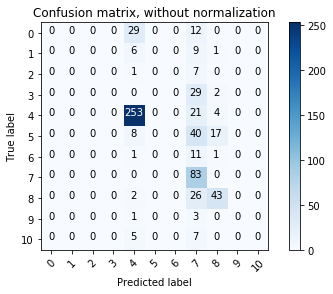

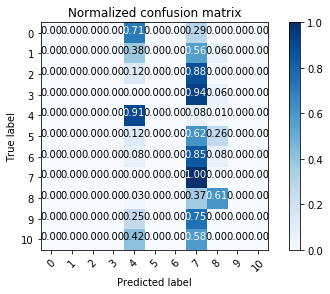

Wall time: 28min 46s


In [15]:
%%time
X_rt_train, y_rt_train, X_rt_test, y_rt_test = divide_to_train_end_test(X_rt_U, y_rt_U, num_categories=11)


model_rt, history_rt, test_scores_rt = run_VGG16_without_retrain_on_dataset(X_rt_train, y_rt_train,
                                                                           X_rt_test, y_rt_test,
                                                                           categories_count=11,
                                                                           patience=7)

In [16]:
print("right_top result accuracy: %.4f" % test_scores_rt[1])

right_top result accuracy: 0.6093


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 11)                90123     
Total params: 14,804,811
Trainable params: 90,123
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/300
5531/5531 [==============================] - 82s 15ms/step - loss: 7.3414 - acc: 0.5306 - val_loss: 6.6514 - val_acc: 0.5836
Epoch 2/300
5531/5531 [==============================] - 81s 15ms/st

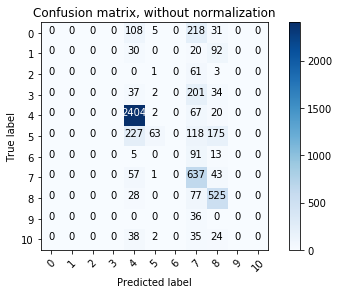

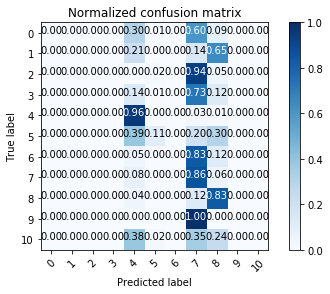

Confusion matrix, without normalization
[[  0   0   0   0   6   3   0  32   0   0   0]
 [  0   0   0   0   5   0   0   4   7   0   0]
 [  0   0   0   0   0   0   0   8   0   0   0]
 [  0   0   0   0   2   0   0  29   0   0   0]
 [  0   0   0   0 207   1   0  21  49   0   0]
 [  0   0   0   0  14   0   0  37  14   0   0]
 [  0   0   0   0   0   0   0  13   0   0   0]
 [  0   0   0   0   0   1   0  77   5   0   0]
 [  0   0   0   0   3   0   0  23  45   0   0]
 [  0   0   0   0   0   0   0   3   1   0   0]
 [  0   0   0   0   5   0   0   7   0   0   0]]
Normalized confusion matrix
[[0.         0.         0.         0.         0.14634146 0.07317073
  0.         0.7804878  0.         0.         0.        ]
 [0.         0.         0.         0.         0.3125     0.
  0.         0.25       0.4375     0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.0645

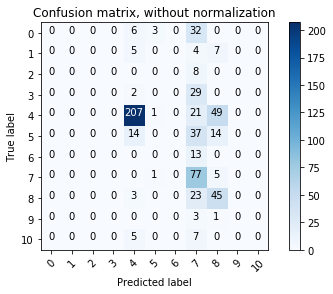

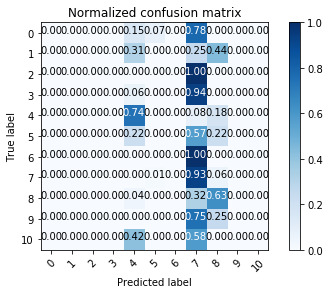

Wall time: 23min 21s


In [17]:
%%time
X_lb_train, y_lb_train, X_lb_test, y_lb_test = divide_to_train_end_test(X_lb_U, y_lb_U, num_categories=11)


model_lb, history_lb, test_scores_lb = run_VGG16_without_retrain_on_dataset(X_lb_train, y_lb_train,
                                                                           X_lb_test, y_lb_test,
                                                                           categories_count=11,
                                                                           patience=7)

In [18]:
print("left_bottom result accuracy: %.4f" % test_scores_lb[1])

left_bottom result accuracy: 0.5289


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 11)                90123     
Total params: 14,804,811
Trainable params: 90,123
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/300
5531/5531 [==============================] - 81s 15ms/step - loss: 7.0304 - acc: 0.5442 - val_loss: 6.7361 - val_acc: 0.5788
Epoch 2/300
5531/5531 [==============================] - 80s 15ms/st

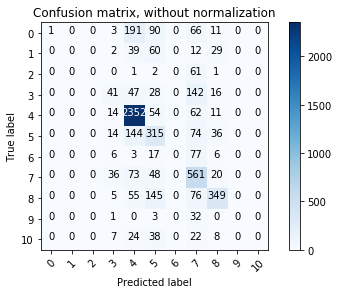

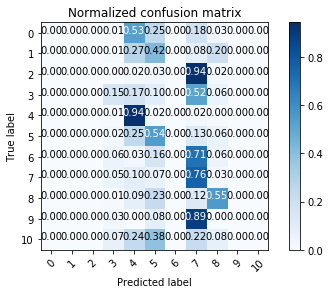

Confusion matrix, without normalization
[[  0   0   0   0  21   7   0  12   1   0   0]
 [  0   0   0   0   6   5   0   5   0   0   0]
 [  0   0   0   0   0   0   0   8   0   0   0]
 [  0   0   0   0   1   0   0  30   0   0   0]
 [  0   0   0   0 194  44   0  13  27   0   0]
 [  0   0   0   0   8  19   0  36   2   0   0]
 [  0   0   0   0   0   0   0  13   0   0   0]
 [  0   0   0   0   0   2   0  79   2   0   0]
 [  0   0   0   0   4  25   0  18  24   0   0]
 [  0   0   0   0   0   1   0   3   0   0   0]
 [  0   0   0   0   2   4   0   6   0   0   0]]
Normalized confusion matrix
[[0.         0.         0.         0.         0.51219512 0.17073171
  0.         0.29268293 0.02439024 0.         0.        ]
 [0.         0.         0.         0.         0.375      0.3125
  0.         0.3125     0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.

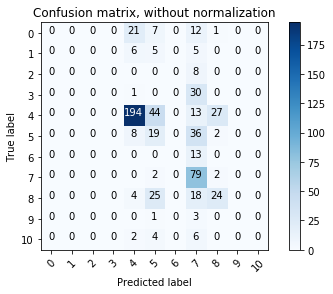

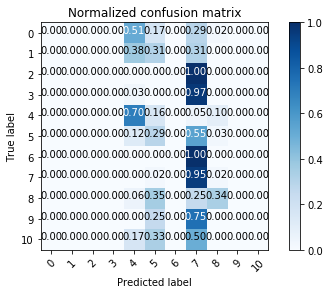

Wall time: 11min 8s


In [19]:
%%time
X_rb_train, y_rb_train, X_rb_test, y_rb_test = divide_to_train_end_test(X_rb_U, y_rb_U, num_categories=11)


model_rb, history_rb, test_scores_rb = run_VGG16_without_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=11,
                                                                           patience=7)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 11)                90123     
Total params: 14,804,811
Trainable params: 90,123
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/300
5531/5531 [==============================] - 84s 15ms/step - loss: 7.3743 - acc: 0.5241 - val_loss: 7.8230 - val_acc: 0.5000
Epoch 2/300
5531/5531 [==============================] - 81s 15ms/st

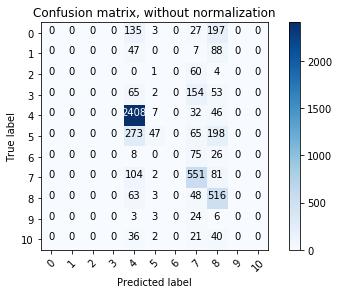

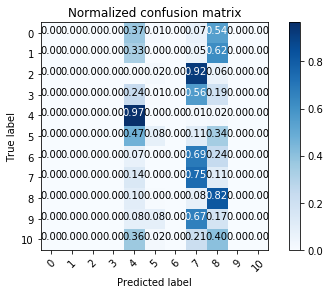

Confusion matrix, without normalization
[[  0   0   0   0  20   3   0   7  11   0   0]
 [  0   0   0   0   8   1   0   4   3   0   0]
 [  0   0   0   0   0   0   0   8   0   0   0]
 [  0   0   0   0   2   0   0  29   0   0   0]
 [  0   0   0   0 205   3   0  13  57   0   0]
 [  0   0   0   0  14   0   0  36  15   0   0]
 [  0   0   0   0   2   0   0  11   0   0   0]
 [  0   0   0   0   3   0   0  74   6   0   0]
 [  0   0   0   0  11   0   0   7  53   0   0]
 [  0   0   0   0   0   2   0   2   0   0   0]
 [  0   0   0   0   3   0   0   8   1   0   0]]
Normalized confusion matrix
[[0.         0.         0.         0.         0.48780488 0.07317073
  0.         0.17073171 0.26829268 0.         0.        ]
 [0.         0.         0.         0.         0.5        0.0625
  0.         0.25       0.1875     0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.

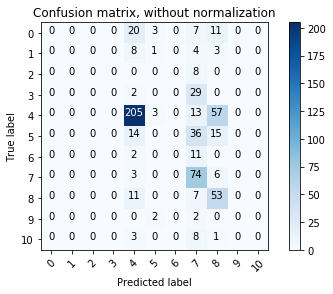

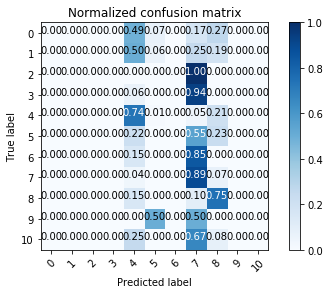

Wall time: 20min 39s


In [21]:
%%time
model_rb_1, history_rb_1, test_scores_rb_1 = run_VGG16_without_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=11,
                                                                           patience=7)

In [22]:
model_rb = model_rb_1
history_rb = history_rb_1
test_scores_rb = test_scores_rb_1

In [23]:
print("right_bottom result accuracy: %.4f" % test_scores_rb[1])

right_bottom result accuracy: 0.5338


## Validation accuracy results

In [24]:
print("center result accuracy: %.4f" % test_scores_ct[1])
print("left_top result accuracy: %.4f" % test_scores_lt[1])
print("right_top result accuracy: %.4f" % test_scores_rt[1])
print("left_bottom result accuracy: %.4f" % test_scores_lb[1])
print("right_bottom result accuracy: %.4f" % test_scores_rb[1])

center result accuracy: 0.6302
left_top result accuracy: 0.5611
right_top result accuracy: 0.6093
left_bottom result accuracy: 0.5289
right_bottom result accuracy: 0.5338


In [25]:
%%time
predict_result_ct_train = model_ct.predict(X_ct_train)
predict_result_ct_test = model_ct.predict(X_ct_test)

predict_result_lt_train = model_lt.predict(X_lt_train)
predict_result_lt_test = model_lt.predict(X_lt_test)

predict_result_rt_train = model_rt.predict(X_rt_train)
predict_result_rt_test = model_rt.predict(X_rt_test)

predict_result_lb_train = model_lb.predict(X_lb_train)
predict_result_lb_test = model_lb.predict(X_lb_test)

predict_result_rb_train = model_rb.predict(X_rb_train)
predict_result_rb_test = model_rb.predict(X_rb_test)

Wall time: 1min 6s


In [26]:
predict_un_train = np.concatenate((predict_result_ct_train,
                                  predict_result_lt_train,
                                  predict_result_rt_train,
                                  predict_result_lb_train,
                                  predict_result_rb_train), axis=1)
print(predict_un_train.shape)

(5531, 55)


In [27]:
predict_un_test = np.concatenate((predict_result_ct_test,
                                  predict_result_lt_test,
                                  predict_result_rt_test,
                                  predict_result_lb_test,
                                  predict_result_rb_test), axis=1)
print(predict_un_test.shape)

(622, 55)


In [28]:
# than write this arrays into file
file_path_un_train = "./VGG16_un_train_USA.npy"
np.save(file_path_un_train, predict_un_train)

file_path_un_test = "./VGG16_un_test_USA.npy"
np.save(file_path_un_test, predict_un_test)

file_path_y_train = "./VGG16_y_train_USA.npy"
np.save(file_path_y_train, y_ct_train)

file_path_y_test = "./VGG16_y_test_USA.npy"
np.save(file_path_y_test, y_ct_test)

In [29]:
#np.load(file_path_un_train)

test accuracy:  0.4711

Confusion matrix, without normalization
[[ 336    0    0    4    4   17    0    0    1    0    0]
 [  19  112    0    2    2    5    0    1    1    0    0]
 [   2    0   40   23    0    0    0    0    0    0    0]
 [  21    0    0  242    1    7    0    1    2    0    0]
 [  34    0    0    6 2421   31    0    1    0    0    0]
 [  54    0    0   31   25  464    0    0    9    0    0]
 [   3    0    0   49    1    4   51    1    0    0    0]
 [  33    0    0  417   10    9    0  269    0    0    0]
 [ 201    0    0   23    0   51    0    1  354    0    0]
 [   3    0    0   12    0    0    0    1    0   20    0]
 [  13    0    0    6    2   13    0    2    0    0   63]]
Normalized confusion matrix
[[9.28176796e-01 0.00000000e+00 0.00000000e+00 1.10497238e-02
  1.10497238e-02 4.69613260e-02 0.00000000e+00 0.00000000e+00
  2.76243094e-03 0.00000000e+00 0.00000000e+00]
 [1.33802817e-01 7.88732394e-01 0.00000000e+00 1.40845070e-02
  1.40845070e-02 3.52112676e-02 0.0

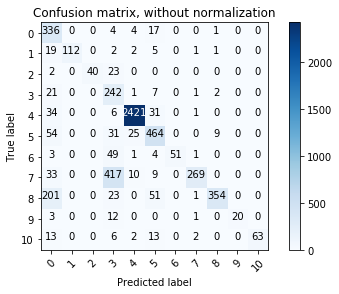

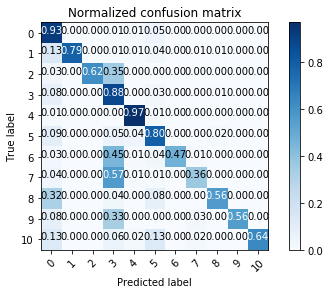

Confusion matrix, without normalization
[[ 33   1   0   1   2   4   0   0   0   0   0]
 [  5   1   0   3   2   5   0   0   0   0   0]
 [  2   0   0   5   0   0   0   0   1   0   0]
 [  0   0   1  27   1   0   0   2   0   0   0]
 [ 47   0   0   8 200  18   0   3   2   0   0]
 [ 15   0   0  26   1   6   0   3  10   0   4]
 [  5   0   0   6   0   0   0   2   0   0   0]
 [  4   2   0  71   0   2   0   3   1   0   0]
 [ 24   3   0   5   0   3   0   1  34   0   1]
 [  0   0   0   2   0   1   0   0   0   1   0]
 [  3   0   0   4   5   0   0   0   0   0   0]]
Normalized confusion matrix
[[0.80487805 0.02439024 0.         0.02439024 0.04878049 0.09756098
  0.         0.         0.         0.         0.        ]
 [0.3125     0.0625     0.         0.1875     0.125      0.3125
  0.         0.         0.         0.         0.        ]
 [0.25       0.         0.         0.625      0.         0.
  0.         0.         0.125      0.         0.        ]
 [0.         0.         0.03225806 0.87096774 0.

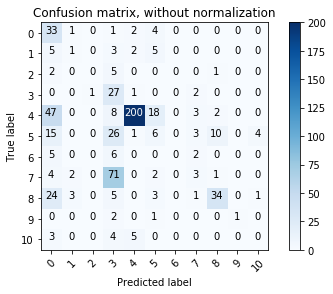

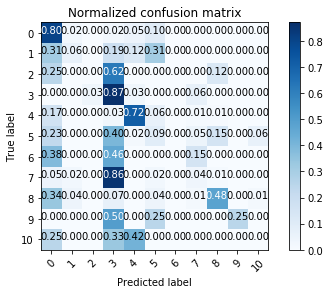

In [30]:
#let's try KNN with another weights
categories_count = 11

knn_distance_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_distance_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_distance_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_distance_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_distance_15)
print("")

print_confusion_matrix(knn_distance_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [31]:
knn_distance_15_predict_train = knn_distance_15.predict(predict_un_train)
knn_distance_15_predict_test = knn_distance_15.predict(predict_un_test)

file_path_knn_distance_15_train = "./VGG16_knn_distance_15_train_USA.npy"
np.save(file_path_knn_distance_15_train, knn_distance_15_predict_train)

file_path_knn_distance_15_test = "./VGG16_knn_distance_15_test_USA.npy"
np.save(file_path_knn_distance_15_test, knn_distance_15_predict_test)


In [32]:
# than SVM
svm = SVC(kernel='rbf')
svm.fit(predict_un_train, y_ct_train)

acc_svm = accuracy_score(y_ct_test, svm.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_svm)
print("")

#print_confusion_matrix(svm, predict_un_train, y_ct_train, 
#                       predict_un_test, y_ct_test, categories_count=categories_count)

test accuracy:  0.5997



In [33]:
def print_confusion_matrix(X, y, y_pred, categories_count):

    cnf_matrix = confusion_matrix(y, y_pred)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 214    1    0    0   19   83    0   27   18    0    0]
 [   9   60    0    0   11   43    0   11    8    0    0]
 [   0    1   12    0    2    1    0   49    0    0    0]
 [  14    7    0    0   27   29    0  181   16    0    0]
 [  24    4    0    0 2351   93    0   18    3    0    0]
 [  45   11    0    0   55  311    0   62   99    0    0]
 [   2    1    0    0    2    5    0   93    6    0    0]
 [   8    3    1    0   34   39    0  633   20    0    0]
 [   5   16    0    0    2   37    0   61  509    0    0]
 [   0    0    0    0    1    0    0   34    1    0    0]
 [  21    3    0    0    5   31    0   21   18    0    0]]
Normalized confusion matrix
[[0.59116022 0.00276243 0.         0.         0.05248619 0.22928177
  0.         0.07458564 0.04972376 0.         0.        ]
 [0.06338028 0.42253521 0.         0.         0.07746479 0.3028169
  0.         0.07746479 0.05633803 0.         0.        ]
 [0.         0.0153

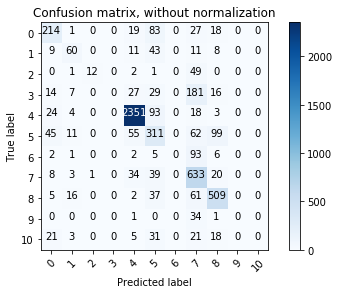

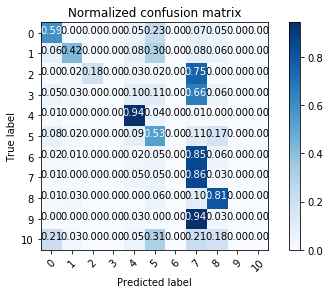

In [34]:
print("TRAIN CONFUSION MATRIX")
y_train_pred = svm.predict(predict_un_train)
print_confusion_matrix(predict_un_train, y_ct_train, y_train_pred, 11)

In [35]:
svm_predict_train = svm.predict(predict_un_train)
svm_predict_test = svm.predict(predict_un_test)

file_path_svm_train = "./VGG16_svm_train_USA"
np.save(file_path_svm_train, svm_predict_train)

file_path_svm_test = "./VGG16_svm_test_USA.npy"
np.save(file_path_svm_test, svm_predict_test)


In [36]:
%%time
# and also multilayer neuron net
categories_count = 11

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=predict_un_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history_callback = meta_net.fit(predict_un_train, one_hot(y_ct_train, categories_count), 
                            validation_data=(predict_un_test, one_hot(y_ct_test, categories_count)),
                            epochs=300, batch_size=10, callbacks=[callback])

test_scores = meta_net.evaluate(predict_un_test, one_hot(y_ct_test, categories_count), verbose=0)
    
#print_confusion_matrix(meta_net, predict_un_train, y_ct_train, predict_un_test, y_ct_test, categories_count)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               28672     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 11)                2827      
Total params: 162,827
Trainable params: 162,827
Non-trainable params: 0
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/300
5531/5531 [==============================] - 14s 3ms/step - loss: 1.0174

In [37]:
print("test accuracy:  %.4f" % test_scores[1])
print("best test accuracy: %.4f" % max(history_callback.history['val_acc']))

test accuracy:  0.6093
best test accuracy: 0.6704


In [38]:
meta_net_predict_train = meta_net.predict(predict_un_train)
meta_net_predict_test = meta_net.predict(predict_un_test)

file_path_meta_net_train = "./VGG16_meta_net_train_USA"
np.save(file_path_meta_net_train, meta_net_predict_train)

file_path_meta_net_test = "./VGG16_meta_net_test_USA.npy"
np.save(file_path_meta_net_test, meta_net_predict_test)


In [41]:
y_ct_train.shape

(5531,)

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 323    0    0    0   14    8    0    5   12    0    0]
 [  85   38    0    0   10    0    0    3    6    0    0]
 [  14    0   24    0    0    0    0   27    0    0    0]
 [ 114    0    0    0   23    4    0  124    9    0    0]
 [ 137    0    0    0 2349    5    0    1    1    0    0]
 [ 343    3    0    0   48   79    0   35   75    0    0]
 [  30    0    0    0    2    0   12   59    6    0    0]
 [ 223    0    1    0   33    1    0  467   13    0    0]
 [ 135    0    0    0    6    5    0   27  457    0    0]
 [  17    0    0    0    0    0    1   18    0    0    0]
 [  65    2    0    0    5    2    0   11   14    0    0]]
Normalized confusion matrix
[[8.92265193e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.86740331e-02 2.20994475e-02 0.00000000e+00 1.38121547e-02
  3.31491713e-02 0.00000000e+00 0.00000000e+00]
 [5.98591549e-01 2.67605634e-01 0.00000000e+00 0.00000000e+00
  7.04225352e-02 0.00000000e+00 0.00

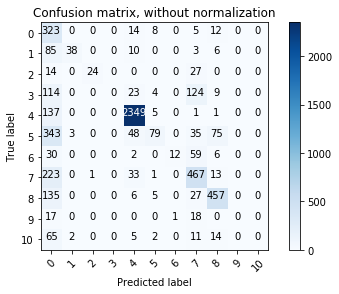

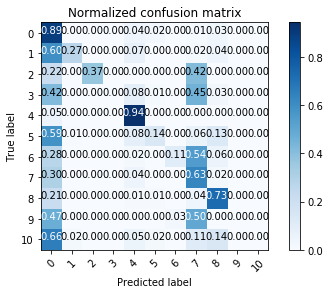


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 36   0   0   0   0   4   0   1   0   0   0]
 [  7   1   0   0   3   1   0   4   0   0   0]
 [  1   0   0   0   0   0   0   7   0   0   0]
 [  3   0   1   0   0   0   0  27   0   0   0]
 [ 66   0   0   0 203   0   0   6   3   0   0]
 [ 24   0   1   0   0   0   0  27  13   0   0]
 [  6   0   0   0   0   0   0   7   0   0   0]
 [ 10   0   0   0   0   0   0  72   1   0   0]
 [ 29   0   0   0   0   0   0   5  37   0   0]
 [  1   0   0   0   0   1   0   2   0   0   0]
 [  2   0   0   0   5   0   0   5   0   0   0]]
Normalized confusion matrix
[[0.87804878 0.         0.         0.         0.         0.09756098
  0.         0.02439024 0.         0.         0.        ]
 [0.4375     0.0625     0.         0.         0.1875     0.0625
  0.         0.25       0.         0.         0.        ]
 [0.125      0.         0.         0.         0.         0.
  0.         0.875      0.         0.         0.        ]
 [0.09677419 0.         0

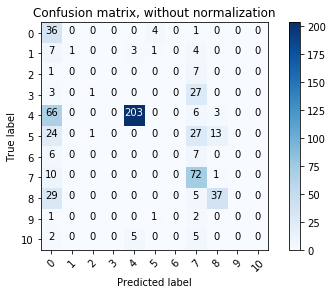

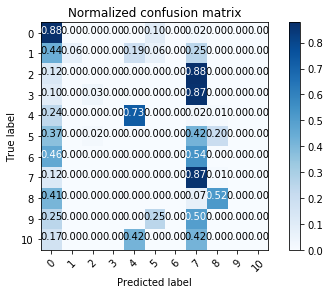

In [42]:
print("TRAIN CONFUSION MATRIX")
print_confusion_matrix(predict_un_train, y_ct_train, (meta_net_predict_train.round()).argmax(axis=1), 11)
print("")

print("TEST CONFUSION MATRIX")
print_confusion_matrix(predict_un_test, y_ct_test, (meta_net_predict_test.round()).argmax(axis=1), 11)

In [43]:
%%time
# and also multilayer neuron net
categories_count = 11

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=predict_un_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history_callback = meta_net.fit(predict_un_train, one_hot(y_ct_train, categories_count), 
                            validation_data=(predict_un_test, one_hot(y_ct_test, categories_count)),
                            epochs=300, batch_size=10, callbacks=[callback])

test_scores = meta_net.evaluate(predict_un_test, one_hot(y_ct_test, categories_count), verbose=0)
    
#print_confusion_matrix(meta_net, predict_un_train, y_ct_train, predict_un_test, y_ct_test, categories_count)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               28672     
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 11)                2827      
Total params: 162,827
Trainable params: 162,827
Non-trainable params: 0
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/300
5531/5531 [==============================] - 14s 3ms/step - loss: 1.0201

In [44]:
print("test accuracy:  %.4f" % test_scores[1])
print("best test accuracy: %.4f" % max(history_callback.history['val_acc']))

test accuracy:  0.6543
best test accuracy: 0.6656


In [46]:
meta_net_predict_train = meta_net.predict(predict_un_train)
meta_net_predict_test = meta_net.predict(predict_un_test)

file_path_meta_net_train = "./VGG16_meta_net_train_USA"
np.save(file_path_meta_net_train, meta_net_predict_train)

file_path_meta_net_test = "./VGG16_meta_net_test_USA.npy"
np.save(file_path_meta_net_test, meta_net_predict_test)


TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 321    0    0    0   15    8    0    6   12    0    0]
 [  79   38    0    0   14    0    0    5    6    0    0]
 [  25    0   12    0    0    1    0   27    0    0    0]
 [  95    0    0    0   25    4    0  142    8    0    0]
 [ 128    0    0    0 2357    6    0    1    1    0    0]
 [ 337    1    0    0   53   81    0   44   67    0    0]
 [  20    0    0    0    2    0    9   72    6    0    0]
 [ 160    0    0    0   34    1    0  533   10    0    0]
 [ 136    0    0    0   12    5    0   39  438    0    0]
 [   8    0    0    0    1    0    1   26    0    0    0]
 [  61    2    0    0    5    2    0   15   14    0    0]]
Normalized confusion matrix
[[8.86740331e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.14364641e-02 2.20994475e-02 0.00000000e+00 1.65745856e-02
  3.31491713e-02 0.00000000e+00 0.00000000e+00]
 [5.56338028e-01 2.67605634e-01 0.00000000e+00 0.00000000e+00
  9.85915493e-02 0.00000000e+00 0.00

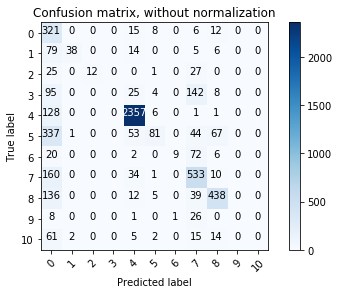

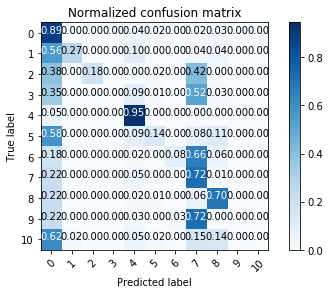


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 36   0   0   0   0   4   0   1   0   0   0]
 [  7   1   0   0   3   1   0   4   0   0   0]
 [  0   0   0   0   1   0   0   7   0   0   0]
 [  1   0   1   0   0   0   0  29   0   0   0]
 [ 61   0   0   0 207   0   0   7   3   0   0]
 [ 23   0   0   0   1   0   0  28  13   0   0]
 [  5   0   0   0   0   0   0   8   0   0   0]
 [  6   0   0   0   0   0   0  76   1   0   0]
 [ 28   0   0   0   0   0   0   8  35   0   0]
 [  1   0   0   0   0   1   0   2   0   0   0]
 [  1   0   0   0   5   0   0   6   0   0   0]]
Normalized confusion matrix
[[0.87804878 0.         0.         0.         0.         0.09756098
  0.         0.02439024 0.         0.         0.        ]
 [0.4375     0.0625     0.         0.         0.1875     0.0625
  0.         0.25       0.         0.         0.        ]
 [0.         0.         0.         0.         0.125      0.
  0.         0.875      0.         0.         0.        ]
 [0.03225806 0.         0

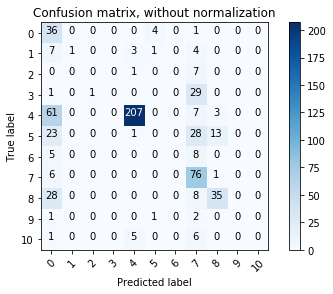

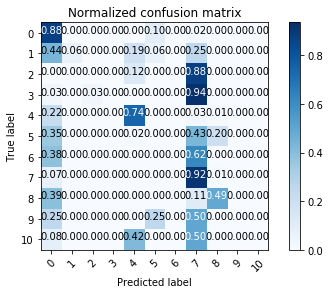

In [47]:
print("TRAIN CONFUSION MATRIX")
print_confusion_matrix(predict_un_train, y_ct_train, (meta_net_predict_train.round()).argmax(axis=1), 11)
print("")

print("TEST CONFUSION MATRIX")
print_confusion_matrix(predict_un_test, y_ct_test, (meta_net_predict_test.round()).argmax(axis=1), 11)